In [2]:
# Import all modules
%matplotlib inline
import warnings
import time
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
from get_test_outputs_resnet import *
import pickle
import matplotlib.colors as mcolors
from PIL import Image
import scipy
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.distributed as dist
import torch.optim
import torch.utils.data
import torch.utils.data.distributed
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import h5py
import torch.utils.data
# Import Tensorflow with multiprocessing
import multiprocessing as mp
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
import sys, pickle
from IPython.display import clear_output
from ipywidgets import interact

def load_AwA():
    train_input = np.squeeze(np.load('train_input.npy'))
    train_label = np.squeeze(np.load('train_label.npy'))
    val_input = np.squeeze(np.load('val_input.npy'))
    val_label = np.squeeze(np.load('val_label.npy'))
    train_feature = np.squeeze(np.load('train_feature.npy'))
    train_output = np.squeeze(np.load('train_output.npy'))
    val_feature = np.squeeze(np.load('val_feature.npy'))
    val_output = np.squeeze(np.load('val_output.npy'))
    return train_input,train_label,val_input,val_label,train_feature,train_output,val_feature,val_output

def resnet50_model(file):
    model = models.__dict__['resnet50'](pretrained = True)
    model.fc = torch.nn.Linear(2048,50)
    model = torch.nn.DataParallel(model).cuda()
    # optionally resume from a checkpoint
    print("=> loading checkpoint '{}'".format(file))
    checkpoint = torch.load(file)
    best_prec1 = checkpoint['best_prec1']
    model.load_state_dict(checkpoint['state_dict'])
    print("=> loaded checkpoint '{}' (epoch {})"
                  .format(file, checkpoint['epoch'])) 
    feature_model = nn.Sequential(*list(model.module.children())[:-1])
    feature_model = torch.nn.DataParallel(feature_model)
    feature_model = feature_model.cuda()
    return model,feature_model

def compute_test_grad(model,val_input,val_label, test_point=None,eps_array = 0):
    # Compute gradients w.r.t. to the test points
    model.zero_grad()  
    X = Variable(torch.from_numpy(np.expand_dims(val_input[test_point,:],axis=0)+eps_array).cuda(),requires_grad = True)
    test = model(X)[:,val_label[test_point]]
    test = torch.sum(test)
    test.backward()
    eval_grads = X.grad 
    return eval_grads.data.cpu().numpy()

def expand_dims_3(arr):
    return np.expand_dims(np.expand_dims(arr,0),0)

def denormalize(image,mean = [0.485,0.456,0.406],std = [0.229,0.224,0.225]):
    denorm_image = image*expand_dims_3(std) + expand_dims_3(mean)
    denorm_image[denorm_image>=1.0] = 1.0
    denorm_image[denorm_image<=0.0] = 0.0
    return denorm_image

def sample_eps(image,epsilon,N):
    images = np.tile(image,(N,1,1,1))
    dim = images.shape
    norm = np.random.normal
    normal_deviates = np.reshape(norm(size=(dim)),(N,-1))
    total_dim = normal_deviates.shape[1]
    radius = np.linalg.norm(normal_deviates,axis = 1, keepdims=True)
    normal_deviates = normal_deviates * (np.random.rand(N,total_dim)**(1.0/total_dim))
    points = np.reshape(normal_deviates*(epsilon)/radius,dim)
    #print(np.linalg.norm(points[1,:,:,:]))
    return points.astype(np.float32)

# Load dataset
num_classes = 50 #    
model,feature_model = resnet50_model('checkpoint.pth.tar')
model.eval()
# x_train - training data(images), y_train - labels(digits)
train_input,train_label,val_input,val_label,train_feature,train_output,val_feature,val_output = load_AwA() 
x_train = train_input
y_train = train_label
x_test = val_input
y_test = val_label
with open("weight_matrix_AwA_2.pkl", "rb") as input_file:
        [weight_matrix,y_predict] = pickle.load(input_file)

train_output34 = train_feature
test_output34 = val_feature
reset_flag = False
output_test_labels = np.argmax(val_output,axis=1)
output_train_labels = np.argmax(train_output,axis=1)
class_names = dict()
class_names[0] = 'antelope' 
class_names[1] = 'bat'
class_names[2] = 'beaver'
class_names[3] = 'blue whale' 
class_names[4] = 'bobcat'
class_names[5] = 'buffalo' 
class_names[6] = 'chihuahua' 
class_names[7] = 'chimpanzee'
class_names[8] = 'collie' 
class_names[9] = 'cow'
class_names[10] = 'dalmation' 
class_names[11] = 'deer'
class_names[12] = 'dolphin'
class_names[13] = 'elephant' 
class_names[14] = 'fox'
class_names[15] = 'german shepherd' 
class_names[16] = 'giant panda' 
class_names[17] = 'giraffe'
class_names[18] = 'gorilla' 
class_names[19] = 'grizzly bear'
class_names[20] = 'hamster' 
class_names[21] = 'hippopotamus'
class_names[22] = 'horse'
class_names[23] = 'humpback whale' 
class_names[24] = 'killer whale'
class_names[25] = 'leopard' 
class_names[26] = 'lion' 
class_names[27] = 'mole'
class_names[28] = 'moose' 
class_names[29] = 'mouse'
class_names[30] = 'otter' 
class_names[31] = 'ox'
class_names[32] = 'persian cat'
class_names[33] = 'pig' 
class_names[34] = 'polar bear'
class_names[35] = 'rabbit' 
class_names[36] = 'raccoon' 
class_names[37] = 'rat'
class_names[38] = 'rhinoceros' 
class_names[39] = 'seal'
class_names[40] = 'sheep' 
class_names[41] = 'siamese cat'
class_names[42] = 'skunk'
class_names[43] = 'spider monkey' 
class_names[44] = 'squirrel'
class_names[45] = 'tiger' 
class_names[46] = 'walrus' 
class_names[47] = 'weasel'
class_names[48] = 'wolf' 
class_names[49] = 'zebra'

test_point = None

=> loading checkpoint 'checkpoint.pth.tar'
=> loaded checkpoint 'checkpoint.pth.tar' (epoch 90)


In [3]:
test_point = None
from scipy import ndimage
output_test_labels = np.argmax(val_output,axis=1)
output_train_labels = np.argmax(train_output,axis=1)

def plot_top_imgs(x_train, idx_to_plot):
    f, ax = plt.subplots(1,len(idx_to_plot), figsize=(15,40))
    for i in range(len(idx_to_plot)):
        ax[i].imshow(denormalize(x_train[idx_to_plot[i]].transpose(1,2,0)))
        ax[i].set_title('train id%d\npredicted as %s\ntrue label is %s'%(idx_to_plot[i], class_names[output_train_labels[idx_to_plot[i]]], class_names[train_label[idx_to_plot[i]]]))
        ax[i].set_xticks(())
        ax[i].set_yticks(())
    return f, ax

def plot_gradients(grad_1, grad_2):
    f, ax = plt.subplots(1, 2, figsize=(12,40))
    ax[0].imshow(grad_1)
    ax[1].imshow(grad_2)
    ax[0].set_xticks(())
    ax[0].set_yticks(())
    ax[1].set_xticks(())
    ax[1].set_yticks(())
    ax[0].set_title('Ordinary Gradient')
    ax[1].set_title('Refined Gradient')

    
def on_button_clicked1(b):
    # Show top 5 positive examples
    target_class = output_test_labels[test_point]
    tmp = weight_matrix[:, target_class] * np.sum(train_feature * val_feature[test_point,:], axis=1)
    idx = np.flip(np.argsort(tmp), axis=0)
    k_range = idx[:5]
    f, ax = plot_top_imgs(x_train, k_range)
    f.text(0.5, 0.55,'Top %d POSITIVE Images'%(len(k_range)), horizontalalignment='center',
      verticalalignment='center',
      transform=ax[0].transAxes, fontsize=12)

def on_button_clicked2(b):
    # Show top 5 negative examples
    target_class = output_test_labels[test_point]
    tmp = weight_matrix[:, target_class] * np.sum(train_feature * val_feature[test_point,:], axis=1)
    idx = np.argsort(tmp)
    k_range = idx[:5]
    f, ax = plot_top_imgs(x_train, k_range)
    f.text(0.5, 0.55,'Top %d NEGATIVE Images'%(len(k_range)), horizontalalignment='center',
      verticalalignment='center',
      transform=ax[0].transAxes, fontsize=12)

def on_button_clicked3(b):
    # Show gradients
    model.eval()
    # plot the improved saliency map
    image = denormalize(x_test[test_point,:].transpose(1,2,0))
    dot_grad = compute_test_grad(model,val_input,val_label, test_point=test_point,eps_array = 0)
    dot_grad = np.mean(dot_grad,axis = 0)
    saliency_eps = np.sum(np.abs(dot_grad),0)
    perturbed_saliency_eps = saliency_eps/(np.sum(saliency_eps))* (224*224/5)
    top_pixels = -12000
    perturbed_saliency_eps = scipy.ndimage.filters.gaussian_filter(perturbed_saliency_eps, 0.8)
    flat_sal = perturbed_saliency_eps.flatten()
    top_k = np.argpartition(flat_sal,top_pixels)
    flat_sal[top_k[top_pixels:]] = 1
    flat_sal[np.where(flat_sal!=1)] = 0
    sal = np.reshape(flat_sal,(224,224))
    grad_1 = np.expand_dims(sal,axis = 2)* (image)

    for count in range(5):
        epsilon = 100.0
        eps_array = sample_eps(x_test[0], epsilon,80).astype(np.float32)
        if count ==0:
            dot_grad = compute_test_grad(model,val_input,val_label, test_point=test_point,eps_array = eps_array)
        else:
            dot_grad = np.concatenate([dot_grad,compute_test_grad(model,val_input,val_label, test_point=test_point,eps_array = eps_array)],axis = 0)
    dot_grad = np.mean(dot_grad,axis = 0)
    saliency_eps = np.sum(np.abs(dot_grad),0)
    perturbed_saliency_eps = saliency_eps/(np.sum(saliency_eps))* (224*224/5)
    top_pixels = -12000
    perturbed_saliency_eps = scipy.ndimage.filters.gaussian_filter(perturbed_saliency_eps, 0.8)
    flat_sal = perturbed_saliency_eps.flatten()
    top_k = np.argpartition(flat_sal,top_pixels)
    flat_sal[top_k[top_pixels:]] = 1
    flat_sal[np.where(flat_sal!=1)] = 0
    sal = np.reshape(flat_sal,(224,224))
    grad_2 = (np.expand_dims(sal,axis = 2)* (image))

    plot_gradients(grad_1, grad_2)

def on_button_clicked4(b):
    # Reset
    clear_output()
    plt.close()
    global reset_flag
    reset_flag = True

def demo():
    def show(test_point):
        plt.tick_params(
            axis='both',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            top=False,         # ticks along the top edge are off
            left=False,
            labelleft=False,
            labelbottom=False) # labels along the bottom edge are off
        image = denormalize(x_test[test_point,:].transpose(1,2,0))
        plt.imshow(image)
        prediction = class_names[output_test_labels[test_point]]
        true_label = class_names[y_test[test_point]]
        plt.title('An image of [%s] \n predicted as [%s]'%(true_label, prediction))
        
        button1 = widgets.Button(description="Show Top 5 Positive Examples", \
                                 layout=widgets.Layout(width='30%', height='30px'))
        display(button1)
        button1.on_click(on_button_clicked1)

        button2 = widgets.Button(description="Show Top 5 Negative Examples", \
                                 layout=widgets.Layout(width='30%', height='30px'))
        display(button2)
        button2.on_click(on_button_clicked2)

        button2 = widgets.Button(description="Why Is This a [%s]"%prediction,\
                                 layout=widgets.Layout(width='30%', height='30px'))
        display(button2)
        button2.on_click(on_button_clicked3)

    def frame(test_point):
        show(test_point)
        button4 = widgets.Button(description="Try Another Image",\
                                     layout=widgets.Layout(width='30%', height='30px'))
        display(button4)
        button4.on_click(on_button_clicked4)
    
    while True:
        global test_point
        test_point = int(raw_input('Type in the image index (0 ~ 7000) you want the prediction for: '))
        if test_point in range(0, 7452):
            break
    global reset_flag
    reset_flag = False
    frame(test_point)

Type in the image index (0 ~ 7000) you want the prediction for: 19


QnV0dG9uKGRlc2NyaXB0aW9uPXUnU2hvdyBUb3AgNSBQb3NpdGl2ZSBFeGFtcGxlcycsIGxheW91dD1MYXlvdXQoaGVpZ2h0PXUnMzBweCcsIHdpZHRoPXUnMzAlJyksIHN0eWxlPUJ1dHRvblPigKY=


QnV0dG9uKGRlc2NyaXB0aW9uPXUnU2hvdyBUb3AgNSBOZWdhdGl2ZSBFeGFtcGxlcycsIGxheW91dD1MYXlvdXQoaGVpZ2h0PXUnMzBweCcsIHdpZHRoPXUnMzAlJyksIHN0eWxlPUJ1dHRvblPigKY=


QnV0dG9uKGRlc2NyaXB0aW9uPXUnV2h5IElzIFRoaXMgYSBbYW50ZWxvcGVdJywgbGF5b3V0PUxheW91dChoZWlnaHQ9dSczMHB4Jywgd2lkdGg9dSczMCUnKSwgc3R5bGU9QnV0dG9uU3R5bGXigKY=


Button(description=u'Try Another Image', layout=Layout(height=u'30px', width=u'30%'), style=ButtonStyle())

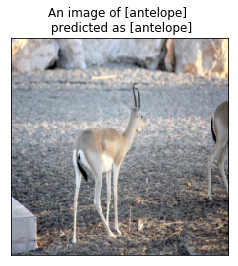

In [4]:
demo()